In [14]:
api_token = {"username":"juliabeltrame","key":"4deafa32ab94951d9fa63bf483de25cb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)


In [ ]:
!kaggle competitions download -c asl-signs

In [16]:
!pip install -q tensorflow-addons
!pip install -q git+https://github.com/hoyso48/tf-utils@main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras.mixed_precision as mixed_precision

from tqdm.autonotebook import tqdm
import sklearn

from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow Version: 2.12.0
Python Version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


<ipython-input-17-f8b6455d81d0>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
# Seed all random number generators
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def get_strategy(device='TPU'):
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            CFG.device = "CPU"

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')

    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy()

connecting to TPU...
REPLICAS: 8


In [20]:
#NOTE: you should run KaggleDatasets.get_gcs_path(dataset_name) in the kaggle notebook to update gcs_path as they expires after several weeks..
#notebook: https://www.kaggle.com/code/hoyso48/islr-get-gcs-path

GCS_PATH = {
            'ISLR':'gs://kds-9c33bbdbe7ee74544591b7ec3cff505c5144f57135f1ad80ed8f21b1',
            '5fold':'gs://kds-f28de167ce31cd39ed4577522f8d78f66230746ff34608f6aa8aeccd',
            '5fold_randsplit':'gs://kds-740b8a3122a1f843fbf5c9356fa90161738ac9918dd0912067b23c62',

# gs://kds-9c33bbdbe7ee74544591b7ec3cff505c5144f57135f1ad80ed8f21b1
# gs://kds-f28de167ce31cd39ed4577522f8d78f66230746ff34608f6aa8aeccd
# gs://kds-740b8a3122a1f843fbf5c9356fa90161738ac9918dd0912067b23c62
            }

TRAIN_FILENAMES = tf.io.gfile.glob(GCS_PATH['5fold']+'/*.tfrecords')
COMPETITION_PATH = GCS_PATH['ISLR']

print(len(TRAIN_FILENAMES))
!gsutil cp {COMPETITION_PATH}/train.csv .
!gsutil cp {COMPETITION_PATH}/sign_to_prediction_index_map.json .

187
Copying gs://kds-9c33bbdbe7ee74544591b7ec3cff505c5144f57135f1ad80ed8f21b1/train.csv...
/ [1 files][  6.1 MiB/  6.1 MiB]                                                
Operation completed over 1 objects/6.1 MiB.                                      
Copying gs://kds-9c33bbdbe7ee74544591b7ec3cff505c5144f57135f1ad80ed8f21b1/sign_to_prediction_index_map.json...
/ [1 files][  3.3 KiB/  3.3 KiB]                                                
Operation completed over 1 objects/3.3 KiB.                                      


In [21]:
# Train DataFrame
train_df = pd.read_csv('train.csv')
display(train_df.head())
display(train_df.info())

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


None

In [22]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return np.sum(n)
print(count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

94477 94477


**Constants:** Constants like ROWS_PER_FRAME, MAX_LEN, etc., set the global variables. These may include the length of the sequence, the number of classes, and landmarks that the model will focus on.

In [25]:
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.


**Lists:**
Lists like NOSE, LIP, POSE, etc., contain indices that seem to correspond to specific landmarks on a face or body. These indices probably map to x, y coordinates in the original data.


In [26]:
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

print(NUM_NODES)
print(CHANNELS)



118
708


**Functions:**
*   interp1d_: Interpolates the time series to target length using specified methods
*   tf_nan_mean: Computes mean ignoring NaNs.
*   tf_nan_std: Computes standard deviation ignoring NaNs.








In [27]:
def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))




**Preprocess Class:**
The class takes in data (inputs) that is assumed to be of shape (N, T, P, C) where N is the batch size, T is the time length, P is the number of landmarks, and C is the channel number.
It centers and standardizes the data based on a 'reference' landmark (index 17, likely the nose).
It reduces the data to 2D, calculating the differences between adjacent frames (dx) and every other frame (dx2).
The output is concatenated into a new tensor which now includes these differences as features, along with the original centered and standardized positions.

In [28]:
class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            x = inputs[None,...]
        else:
            x = inputs

        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)

        x = (x - mean)/std

        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        x = x[...,:2]

        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        x = tf.concat([
            tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)

        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

        return x

In [29]:
# Decode TFRecords and extract features
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'sign': tf.io.FixedLenFeature([], tf.int64),
    })
    out = {}
    out['coordinates']  = tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,ROWS_PER_FRAME,3))
    out['sign'] = features['sign']
    return out


# Filter out NaN values in data
def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    x = tf.boolean_mask(x, mask, axis=0)
    return x

# Preprocess the dataset (filter NaNs, augment data, etc.)
def preprocess(x, augment=False, max_len=MAX_LEN):
    coord = x['coordinates']
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))

    return tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32), tf.one_hot(x['sign'], NUM_CLASSES)

# Flip the coordinates along the left-right axis
def flip_lr(x):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[...,None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[...,None], leye)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

# Resample the coordinates with a random rate
def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32) #(tf.cast(rate*tf.cast(length,tf.float32), tf.int32),tf.shape(x)[1])
    new_x = interp1d_(x, new_size) #tf.image.resize(x, new_size, method='bilinear')
    return new_x


Data Augmentation

In [ ]:
# Apply random affine transformations to spatial coordinates
def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

# Randomly crop time-series data to a given length
def temporal_crop(x, length=MAX_LEN):
    l = tf.shape(x)[0]
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    x = x[offset:offset+length]
    return x

# Apply temporal masking on time-series data
def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_offset, mask_offset+mask_size)[...,None],tf.fill([mask_size,543,3],mask_value))
    return x

# Apply spatial masking on coordinates
def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

# Wrapper function for all augmentation techniques
def augment_fn(x, always=False, max_len=None):
    if tf.random.uniform(())<0.8 or always:
        x = resample(x, (0.5,1.5))
    if tf.random.uniform(())<0.5 or always:
        x = flip_lr(x)
    if max_len is not None:
        x = temporal_crop(x, max_len)
    if tf.random.uniform(())<0.75 or always:
        x = spatial_random_affine(x)
    if tf.random.uniform(())<0.5 or always:
        x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        x = spatial_mask(x)
    return x

Create a dataset from TFRecords with optional data augmentation, batching, and shuffling


In [ ]:

def get_tfrec_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=PAD, padded_shapes=([max_len,CHANNELS],[NUM_CLASSES]), drop_remainder=drop_remainder)

    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

# Example usage of `get_tfrec_dataset`

ds = get_tfrec_dataset(TRAIN_FILENAMES, augment=True, batch_size=1024)
for x in ds:
    temp_train = x
    break

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

# Function to filter out frames that contain all NaNs
def filter_nans(frames):
    return frames[~np.isnan(frames).all(axis=(-2,-1))]

# Reading TFRecords and decoding
ds = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
print(ds)

# Filtering out frames with NaN values for the left hand
for x in ds:
    temp = x['coordinates'].numpy()
    if not len(filter_nans(temp[:,LHAND])) == 0:
        break

#PLOT
# Edges for plotting skeletal structure
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

fig, ax = plt.subplots()


# Function to plot a single frame
def plot_frame(frame, edges=[], idxs=[]):

    frame[np.isnan(frame)] = 0
    x = list(frame[...,0])
    y = list(frame[...,1])
    if len(idxs) == 0:
        idxs = list(range(len(x)))
    ax.clear()
    ax.scatter(x, y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], idxs[i])

    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Function to animate a sequence of frames
def animate_frames(frames, edges=[], idxs=[]):
    anim = FuncAnimation(fig, lambda frame: plot_frame(frame, edges, idxs), frames=frames, interval=100)
    return HTML(anim.to_jshtml())

Animate frames focusing on the left hand landmarks.
Edges specify the connections between the landmarks to be drawn.

In [31]:

animate_frames(
    filter_nans(temp[:, LHAND]),  # Filter out frames with NaN values for left hand landmarks
    edges=edges  # The set of edges to connect landmarks
)

Animate frames focusing on the right hand landmarks after applying data augmentation.
Edges specify the connections between the landmarks to be drawn.


In [32]:
animate_frames(
    filter_nans(augment_fn(temp, always=True).numpy()[:, RHAND]),  # Apply data augmentation and filter out frames with NaN values for right hand landmarks
    edges=edges  # The set of edges to connect landmarks
)

Animate frames focusing on the specific point landmarks defined in POINT_LANDMARKS.
No edges are specified, so only the points will be displayed.


In [33]:
animate_frames(
    filter_nans(temp[:, POINT_LANDMARKS])  # Filter out frames with NaN values for the specified point landmarks
)

Animate the frames after applying augmentation and filtering NaNs.
We focus on the landmarks specified by POINT_LANDMARKS.

In [34]:
animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,POINT_LANDMARKS]), idxs=POINT_LANDMARKS)

In [36]:
class ECA(tf.keras.layers.Layer):
    '''
    Efficient Channel Attention Layer.
    In the context of the ECA (Efficient Channel Attention) layer, "channels" refer to the depth dimension of a 1D sequence.
    Imagine you have a sequence of shape (batch_size, sequence_length, num_channels).
    The num_channels could represent different features at each time step in the sequence.
    For example, if you're working with time-series sensor data, each channel could represent a different sensor's readings over time.
    The purpose of channel attention is to weigh these channels differently based on their importance for a specific task.
    In the ECA layer, a 1D convolution is applied along the channels, which computes attention scores for each channel.
    The attention scores go through a sigmoid activation function, normalizing them between 0 and 1.
    These normalized scores are then used to weight the original channels. The idea is that channels contributing more to a task would get higher
    attention scores, effectively amplifying their impact on the network's output.
    '''
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    '''
    Dropout layer that starts applying dropout after a specified number of steps.
    This custom dropout layer applies dropout only after a specified number of training steps (start_step).
    This can be useful for ensuring that the model first learns the underlying patterns before introducing dropout to prevent overfitting.
    '''
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
          self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    '''
    It's a depthwise 1D convolutional layer that is designed to maintain causality in the sequence data.
    Maintaining causality means ensuring that the output at each time step is dependent only on the current and previous time steps, not on any future steps.
    In many time-series forecasting problems this is important, where future information should not influence the current output.
    Ensures causality by padding zeros to the input.

    This layer performs depthwise 1D convolution but with a twist—causal padding.
    This ensures that the output at time t only depends on the input up to time t, preserving causality which is crucial in time-series data or sequences.
    '''
    def __init__(self,
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    Composite block consisting of several operations:
    - Expansion: It increases the dimensionality of the input channels.
    - Depthwise Convolution: Performs a causal depthwise 1D convolution.
    - Batch Normalization: Normalizes the output.
    - ECA (Efficient Channel Attention): Focuses on important channels.
    - Projection: Reduces the channel dimensionality back to the original.
    - Dropout: Optional dropout for regularization.
    - Residual Connection: If input and output dimensions are the same, it adds the original input back to the output.
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

Multi-head self-attention (key component in Transformer architectures)

In [37]:
# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        # Initialize dimensions and scaling factor
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads

        # Create a dense layer for Q, K, V
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)

        # Dropout layer
        self.drop1 = tf.keras.layers.Dropout(dropout)

        # Projection layer
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        # Compute Q, K, V
        qkv = self.qkv(inputs)

        # Reshape and permute to get individual Q, K, V
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        # Compute attention scores
        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        # Apply mask if provided
        if mask is not None:
            mask = mask[:, None, None, :]

        # Softmax to convert scores to probabilities
        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        # Compute weighted sum of V
        x = attn @ v

        # Reshape and project output
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x

# Transformer Block
def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        # Batch normalization
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(inputs)

        # Multi-Head Self-Attention
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)

        # Dropout and residual connection
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        # Another batch normalization
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)

        # Feed-forward layers
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)

        # Dropout and residual connection
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply


The code appears to be a hybrid model that uses both Convolutional Neural Networks (CNN) and Transformer architectures. Specifically:

Classes like ECA, LateDropout, and CausalDWConv1D are indicative of CNN-based components. For instance, CausalDWConv1D implements a causal 1D depthwise convolution, which is a type of convolutional layer. ECA is used for efficient channel attention, another technique used in CNNs.

On the other hand, MultiHeadSelfAttention and TransformerBlock are clearly related to Transformer architectures. The MultiHeadSelfAttention class implements the multi-head self-attention mechanism, and TransformerBlock constructs a block of a Transformer, including self-attention and feed-forward neural network layers.
So, the model seems to be a fusion of CNN and Transformer elements, aiming to leverage the strengths of both architectures.

In [38]:
def get_model(max_len=64, dropout_step=0, dim=192):
    # Input layer for sequences of length max_len with a dimension of CHANNELS
    inp = tf.keras.Input((max_len, CHANNELS))

    # Masking layer to handle padding
    x = tf.keras.layers.Masking(mask_value=PAD, input_shape=(max_len, CHANNELS))(inp)

    # Initial dense layer to produce feature maps of dimension 'dim'
    x = tf.keras.layers.Dense(dim, use_bias=False, name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, name='stem_bn')(x)

    # Three convolutional blocks with drop rate of 0.2
    ksize = 17
    x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)

    # One Transformer block
    x = TransformerBlock(dim, expand=2)(x)

    # Repeat the previous pattern of three conv blocks and one Transformer block
    x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = TransformerBlock(dim, expand=2)(x)

    # Additional blocks if 'dim' is 384 (likely for a larger model)
    if dim == 384:
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = TransformerBlock(dim, expand=2)(x)

        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = TransformerBlock(dim, expand=2)(x)

    # Final dense layer and pooling
    x = tf.keras.layers.Dense(dim * 2, activation=None, name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dropout layer with rate of 0.8 after 'dropout_step' steps
    x = LateDropout(0.8, start_step=dropout_step)(x)

    # Classification layer
    x = tf.keras.layers.Dense(NUM_CLASSES, name='classifier')(x)

    # Create and return the model
    return tf.keras.Model(inp, x)

# Instantiate and test the model
model = get_model()
y = model(temp_train[0])
tf.keras.losses.CategoricalCrossentropy(from_logits=True)(temp_train[1], y)


<tf.Tensor: shape=(), dtype=float32, numpy=5.8528686>

In [39]:
#check supports_masking
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)


  Core training loop for a single fold in a K-fold cross-validation.
  It sets up the learning rate schedule, optimizers, and other training configurations before kicking off the training process.


In [40]:
def train_fold(CFG, fold, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)

   # Setup for mixed precision training
    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    # Prepare datasets
    if fold != 'all':
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=32768)
        valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, augment=True, repeat=True, shuffle=32768)
        valid_ds = None
        valid_files = []

    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train//CFG.batch_size

    # Model creation and compilation inside strategy scope
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')

        awp_step = CFG.awp_start_epoch * steps_per_epoch
        if CFG.fgm:
            model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.1)],# [tf.keras.losses.CategoricalCrossentropy(from_logits=True)]
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )
    # Model summary and schedule plot if required
    if summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init=False
    print(f'---------fold{fold}---------')
    print(f'train:{num_train} valid:{num_valid}')
    print()
    # Resuming from last checkpoint if CFG.resume is true
    if CFG.resume:
        print(f'resume from epoch{CFG.resume}')
        model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
        if train_ds is not None:
            model.evaluate(train_ds.take(steps_per_epoch))
        if valid_ds is not None:
            model.evaluate(valid_ds)
# Callbacks setup
    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='min', save_freq='epoch')
    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.snapshot_epochs)
    swa = SWA(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds, valid_steps=-(num_valid//-CFG.batch_size))
    callbacks = []
    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)
        if fold != 'all':
            callbacks.append(sv_loss)
   # Actual training
    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=-(num_valid//-CFG.batch_size)
    )
# Post training actions: Model evaluation and possibly load best weights
    if CFG.save_output:
        try:
            model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5')
        except:
            pass
    if fold != 'all':
        cv = model.evaluate(valid_ds,verbose=CFG.verbose,steps=-(num_valid//-CFG.batch_size))
    else:
        cv = None

    return model, cv, history

Function to run training for all folds


In [ ]:
def train_folds(CFG, folds, strategy=STRATEGY, summary=True):
    for fold in folds:
        if fold != 'all':
            all_files = TRAIN_FILENAMES
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            valid_files = [x for x in all_files if f'fold{fold}' in x]
        else:
            train_files = TRAIN_FILENAMES
            valid_files = None

        train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)
    return

Configuration class


In [41]:
class CFG:
    n_splits = 5
    save_output = True
    output_dir = '.'

    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch

    max_len = 384
    replicas = 8
    lr = 5e-4 * replicas
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 300 #400
    warmup = 0
    batch_size = 64 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))

    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'


Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 192)     768         ['stem_conv[0][0]']              
                                                                                               

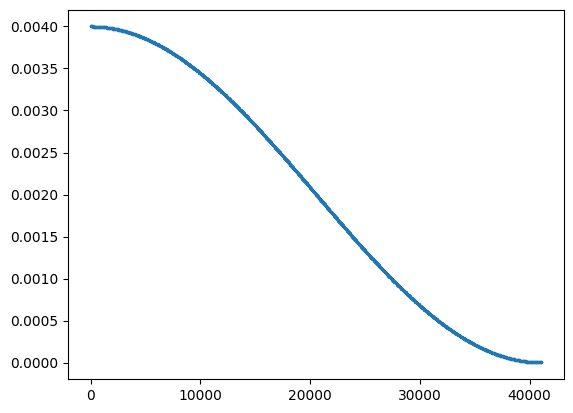


---------fold0---------
train:70611 valid:23866

Epoch 1/300
137/137 - 412s - loss: 5.0624 - categorical_accuracy: 0.0685 - val_loss: 4.0293 - val_categorical_accuracy: 0.2106 - 412s/epoch - 3s/step
Epoch 2/300
137/137 - 40s - loss: 4.0587 - categorical_accuracy: 0.2239 - val_loss: 3.4774 - val_categorical_accuracy: 0.3184 - 40s/epoch - 289ms/step
Epoch 3/300
137/137 - 44s - loss: 3.6286 - categorical_accuracy: 0.3161 - val_loss: 3.0288 - val_categorical_accuracy: 0.4368 - 44s/epoch - 323ms/step
Epoch 4/300
137/137 - 48s - loss: 3.3217 - categorical_accuracy: 0.3856 - val_loss: 2.8796 - val_categorical_accuracy: 0.4676 - 48s/epoch - 354ms/step
Epoch 5/300
137/137 - 35s - loss: 3.1136 - categorical_accuracy: 0.4341 - val_loss: 2.5144 - val_categorical_accuracy: 0.5760 - 35s/epoch - 257ms/step
Epoch 6/300
137/137 - 29s - loss: 2.9456 - categorical_accuracy: 0.4753 - val_loss: 2.5164 - val_categorical_accuracy: 0.5785 - 29s/epoch - 210ms/step
Epoch 7/300
137/137 - 27s - loss: 2.8172 - ca

In [ ]:
train_folds(CFG, [0])

In [ ]:
# CFG.seed = 42
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 43
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 44
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 45
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)